# 📊 Customer Churn Analysis
## Exploratory Data Analysis, Feature Engineering & Data Cleaning

**Author:** Senior Data Engineer  
**Dataset:** Telco Customer Churn  
**Objective:** Extract meaningful features for churn prediction model

---



## 1. Setup & Data Loading



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)



In [3]:
# Load data
df = pd.read_csv('../data/customer_churn.csv')
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()



Dataset Shape: 7,043 rows × 21 columns


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Data Quality Assessment



In [4]:
# Basic info
print("=" * 50)
print("DATA TYPES & NON-NULL COUNTS")
print("=" * 50)
df.info()



DATA TYPES & NON-NULL COUNTS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBill

In [5]:
# Missing values analysis
print("\n" + "=" * 50)
print("MISSING VALUES ANALYSIS")
print("=" * 50)

missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).query('`Missing Count` > 0')

if len(missing_df) == 0:
    print("✅ No missing values detected!")
else:
    print(missing_df.sort_values('Missing %', ascending=False))




MISSING VALUES ANALYSIS
✅ No missing values detected!


In [6]:
# Check for hidden missing values (empty strings, whitespace)
print("\n" + "=" * 50)
print("HIDDEN MISSING VALUES (Empty Strings)")
print("=" * 50)

for col in df.select_dtypes(include='object').columns:
    empty_count = (df[col].str.strip() == '').sum()
    if empty_count > 0:
        print(f"⚠️  {col}: {empty_count} empty strings")

# TotalCharges is known to have this issue
print("\nChecking TotalCharges for non-numeric values...")
non_numeric = pd.to_numeric(df['TotalCharges'], errors='coerce').isna().sum()
print(f"   Non-numeric TotalCharges values: {non_numeric}")




HIDDEN MISSING VALUES (Empty Strings)
⚠️  TotalCharges: 11 empty strings

Checking TotalCharges for non-numeric values...
   Non-numeric TotalCharges values: 11


In [7]:
# Duplicate analysis
print("\n" + "=" * 50)
print("DUPLICATE ANALYSIS")
print("=" * 50)

duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

if 'customerID' in df.columns:
    dup_ids = df['customerID'].duplicated().sum()
    print(f"Duplicate customerIDs: {dup_ids}")




DUPLICATE ANALYSIS
Duplicate rows: 0
Duplicate customerIDs: 0


## 3. Target Variable Analysis



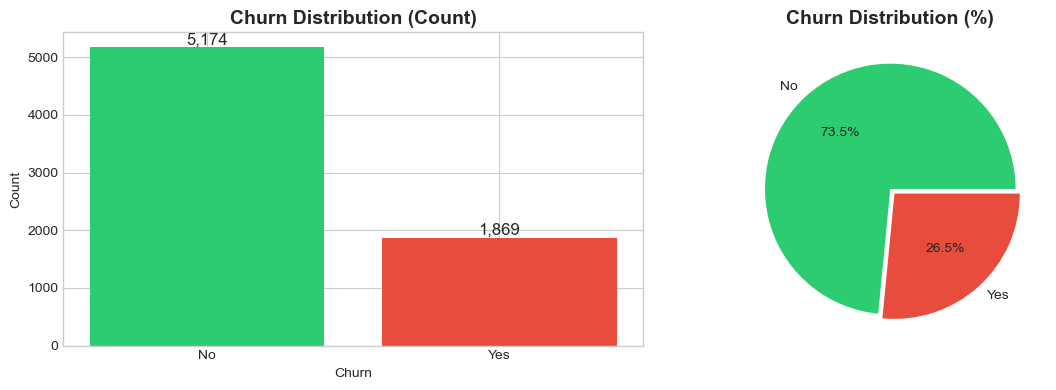


📊 Class Imbalance Ratio: 2.77:1
   Churners: 26.5%  |  Non-Churners: 73.5%


In [8]:
# Churn distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
churn_counts = df['Churn'].value_counts()
ax1 = axes[0]
bars = ax1.bar(churn_counts.index, churn_counts.values, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Churn Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Churn')
ax1.set_ylabel('Count')
for bar, count in zip(bars, churn_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', fontsize=12)

# Percentage
ax2 = axes[1]
churn_pct = df['Churn'].value_counts(normalize=True) * 100
ax2.pie(churn_pct.values, labels=churn_pct.index, autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'], explode=[0, 0.05])
ax2.set_title('Churn Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Class Imbalance Ratio: {churn_counts['No'] / churn_counts['Yes']:.2f}:1")
print(f"   Churners: {churn_pct['Yes']:.1f}%  |  Non-Churners: {churn_pct['No']:.1f}%")



## 4. Numerical Features Analysis



In [9]:
# Identify numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Convert TotalCharges to numeric (handle empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("NUMERICAL FEATURES STATISTICS")
print("=" * 50)
df[numerical_cols].describe()



NUMERICAL FEATURES STATISTICS


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


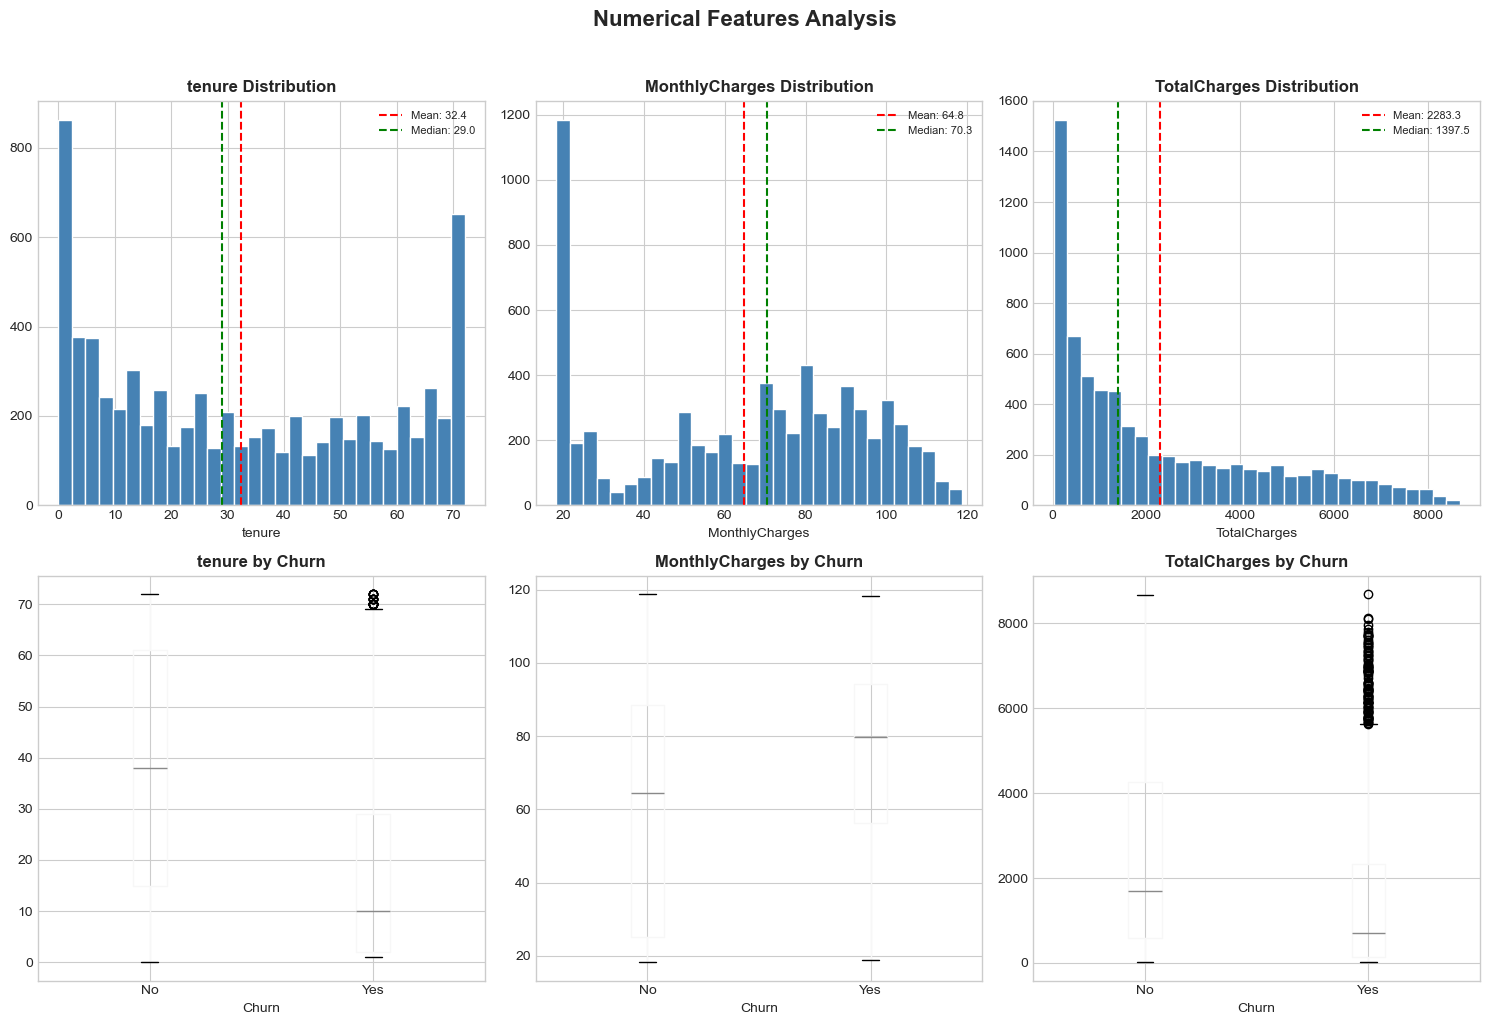

In [10]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    # Histogram
    ax1 = axes[0, i]
    df[col].hist(bins=30, ax=ax1, color='steelblue', edgecolor='white')
    ax1.set_title(f'{col} Distribution', fontweight='bold')
    ax1.set_xlabel(col)
    ax1.axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.1f}')
    ax1.axvline(df[col].median(), color='green', linestyle='--', label=f'Median: {df[col].median():.1f}')
    ax1.legend(fontsize=8)
    
    # Box plot by Churn
    ax2 = axes[1, i]
    df.boxplot(column=col, by='Churn', ax=ax2)
    ax2.set_title(f'{col} by Churn', fontweight='bold')
    ax2.set_xlabel('Churn')

plt.suptitle('Numerical Features Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



In [11]:
# Statistical tests - Are numerical features significantly different between churners?
print("\n" + "=" * 50)
print("STATISTICAL SIGNIFICANCE TESTS (T-Test)")
print("=" * 50)

df_churn = df[df['Churn'] == 'Yes']
df_no_churn = df[df['Churn'] == 'No']

for col in numerical_cols:
    stat, pvalue = stats.ttest_ind(
        df_churn[col].dropna(), 
        df_no_churn[col].dropna()
    )
    significance = "✅ Significant" if pvalue < 0.05 else "❌ Not Significant"
    print(f"{col:20} | p-value: {pvalue:.4e} | {significance}")




STATISTICAL SIGNIFICANCE TESTS (T-Test)
tenure               | p-value: 7.9991e-205 | ✅ Significant
MonthlyCharges       | p-value: 2.7066e-60 | ✅ Significant
TotalCharges         | p-value: 4.8769e-64 | ✅ Significant


## 5. Categorical Features Analysis



In [12]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Churn')
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

print(f"Categorical Features ({len(categorical_cols)}):")
print(categorical_cols)



Categorical Features (15):
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


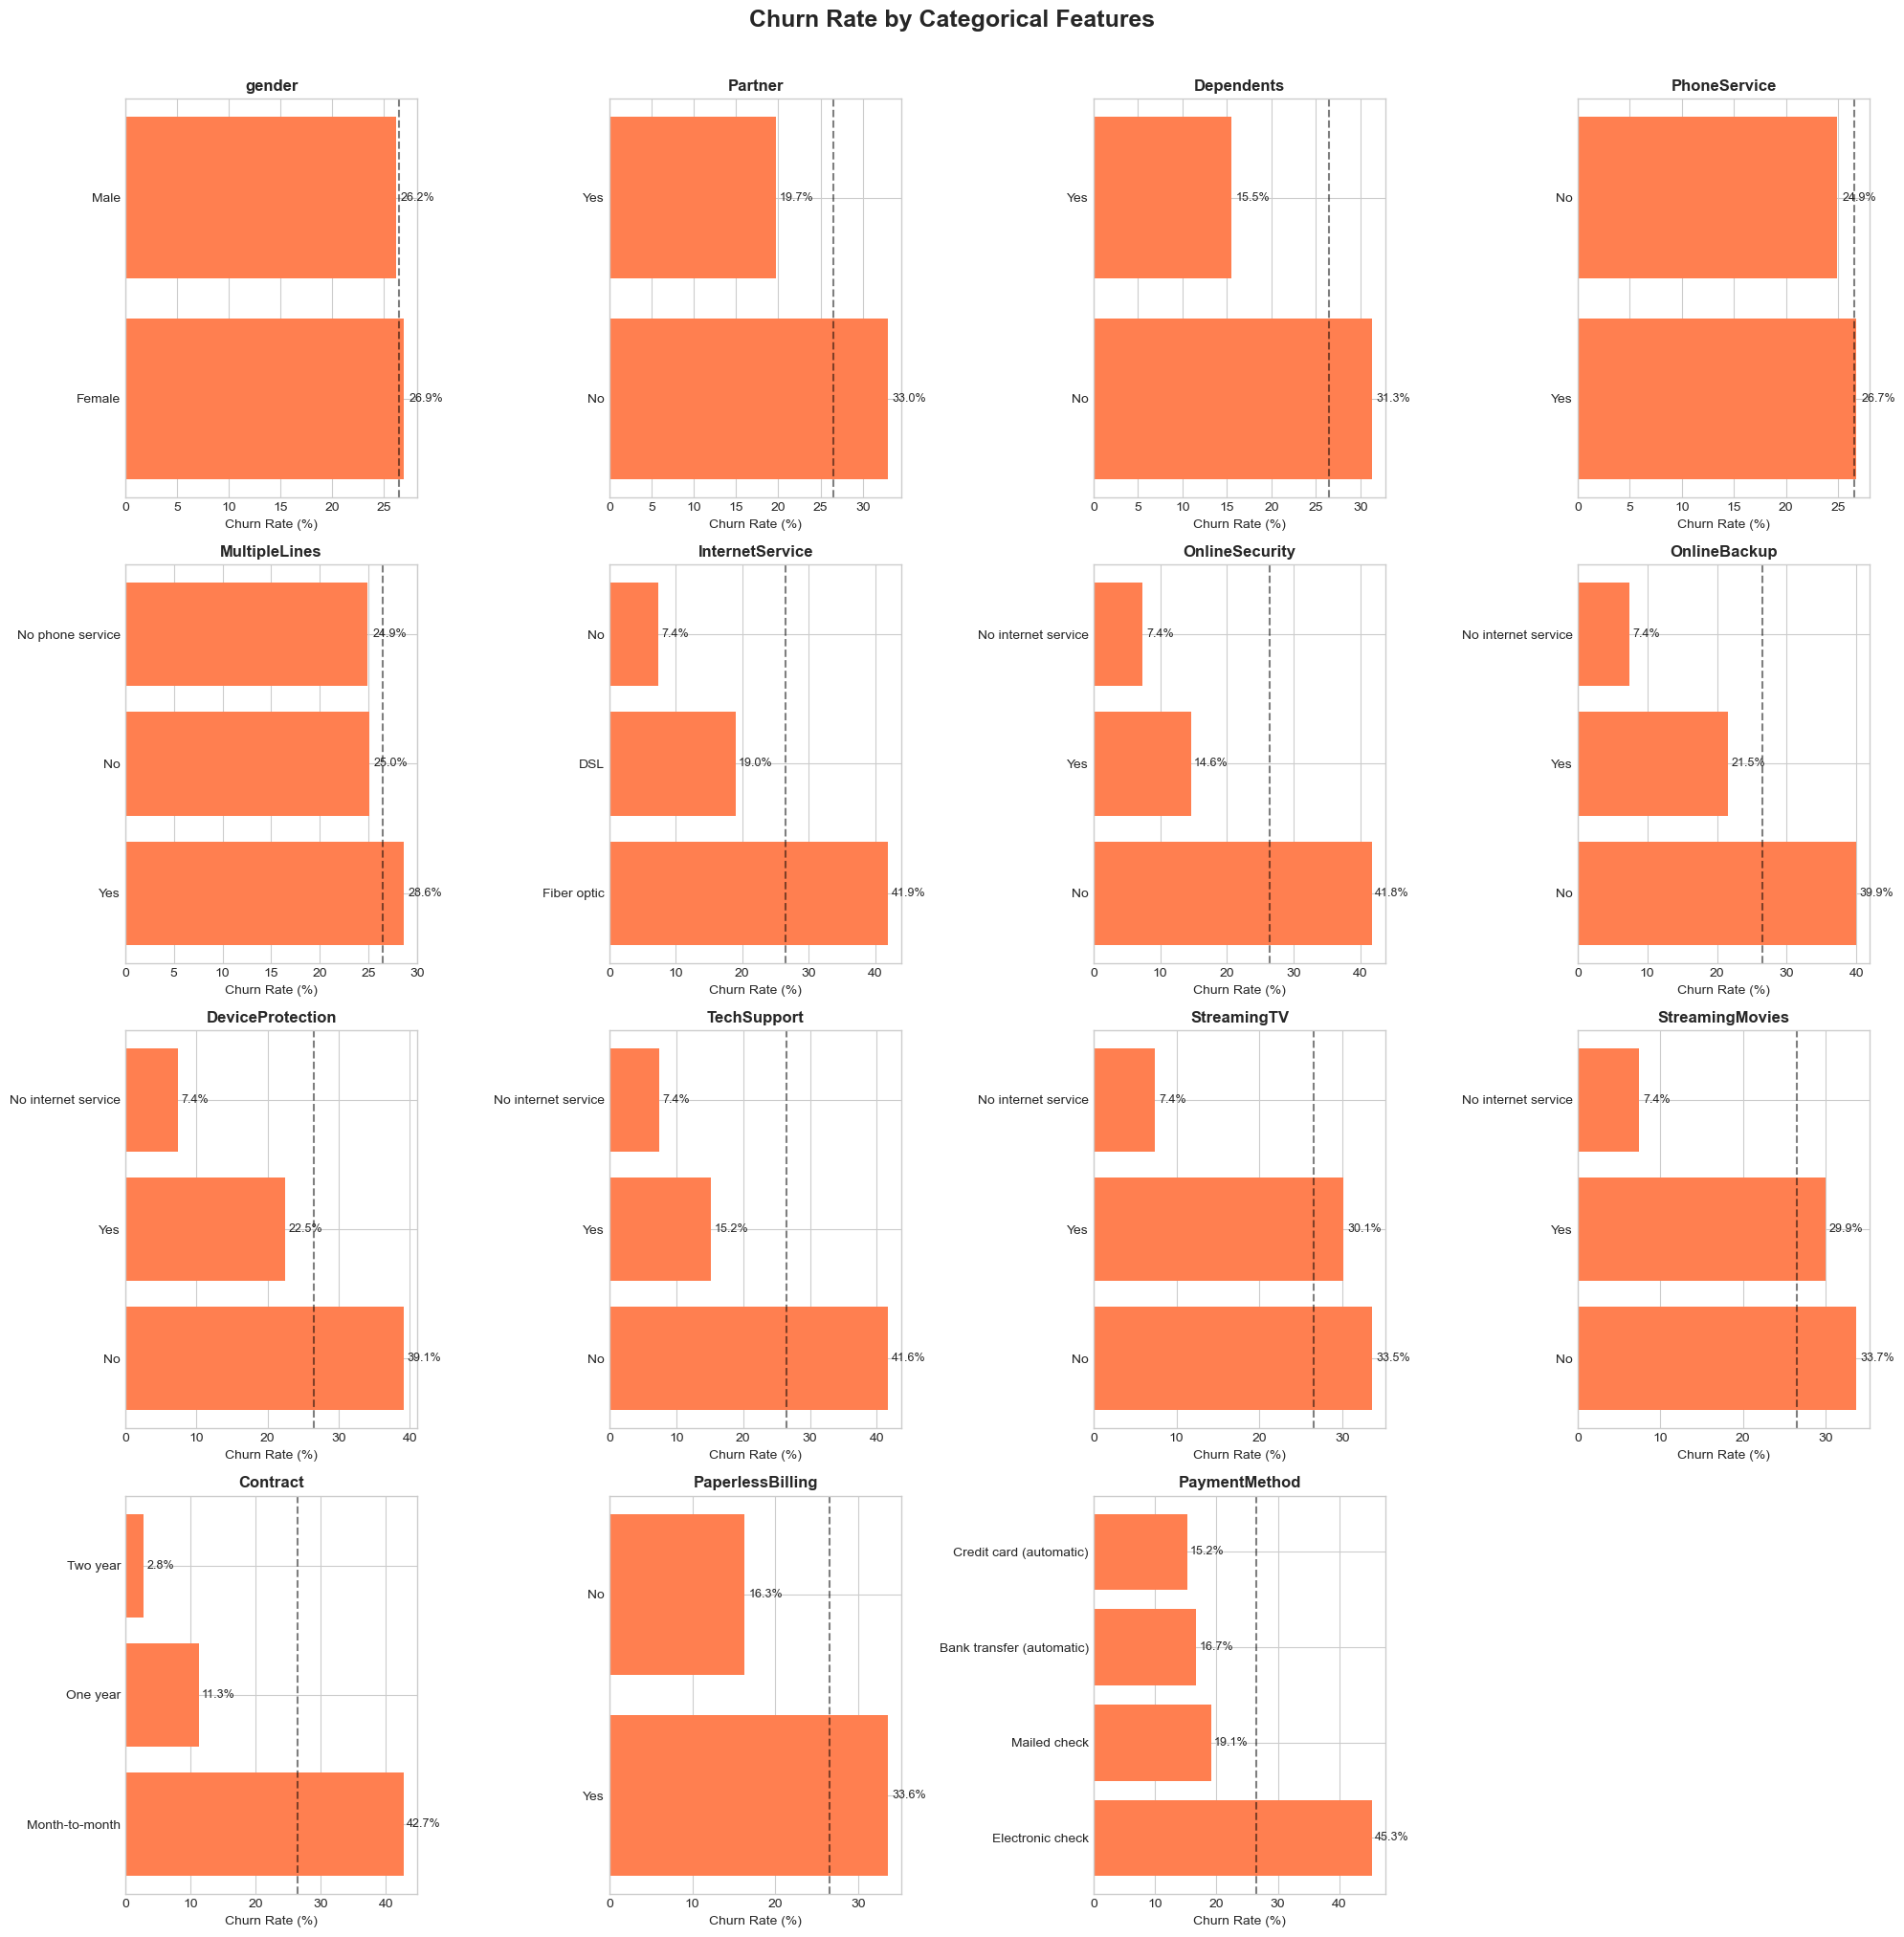

In [13]:
# Churn rate by categorical features
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if i >= 16:
        break
    
    # Calculate churn rate per category
    churn_rate = df.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    churn_rate = churn_rate.sort_values(ascending=False)
    
    ax = axes[i]
    bars = ax.barh(churn_rate.index, churn_rate.values, color='coral')
    ax.set_xlabel('Churn Rate (%)')
    ax.set_title(f'{col}', fontweight='bold')
    ax.axvline(26.5, color='black', linestyle='--', alpha=0.5, label='Baseline')
    
    # Add value labels
    for bar, val in zip(bars, churn_rate.values):
        ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{val:.1f}%', va='center', fontsize=9)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Churn Rate by Categorical Features', fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()



In [14]:
# Chi-Square tests for categorical features
print("\n" + "=" * 50)
print("CHI-SQUARE TESTS (Categorical vs Churn)")
print("=" * 50)

chi2_results = []
for col in categorical_cols:
    contingency = pd.crosstab(df[col], df['Churn'])
    chi2, pvalue, dof, expected = stats.chi2_contingency(contingency)
    significance = "✅" if pvalue < 0.05 else "❌"
    chi2_results.append({
        'Feature': col,
        'Chi2': chi2,
        'p-value': pvalue,
        'Significant': significance
    })

chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')
print(chi2_df.to_string(index=False))




CHI-SQUARE TESTS (Categorical vs Churn)
         Feature        Chi2       p-value Significant
        Contract 1184.596572 5.863038e-258           ✅
  OnlineSecurity  849.998968 2.661150e-185           ✅
     TechSupport  828.197068 1.443084e-180           ✅
 InternetService  732.309590 9.571788e-160           ✅
   PaymentMethod  648.142327 3.682355e-140           ✅
    OnlineBackup  601.812790 2.079759e-131           ✅
DeviceProtection  558.419369 5.505219e-122           ✅
 StreamingMovies  375.661479  2.667757e-82           ✅
     StreamingTV  374.203943  5.528994e-82           ✅
PaperlessBilling  258.277649  4.073355e-58           ✅
      Dependents  189.129249  4.924922e-43           ✅
         Partner  158.733382  2.139911e-36           ✅
   MultipleLines   11.330441  3.464383e-03           ✅
    PhoneService    0.915033  3.387825e-01           ❌
          gender    0.484083  4.865787e-01           ❌


## 6. Correlation Analysis



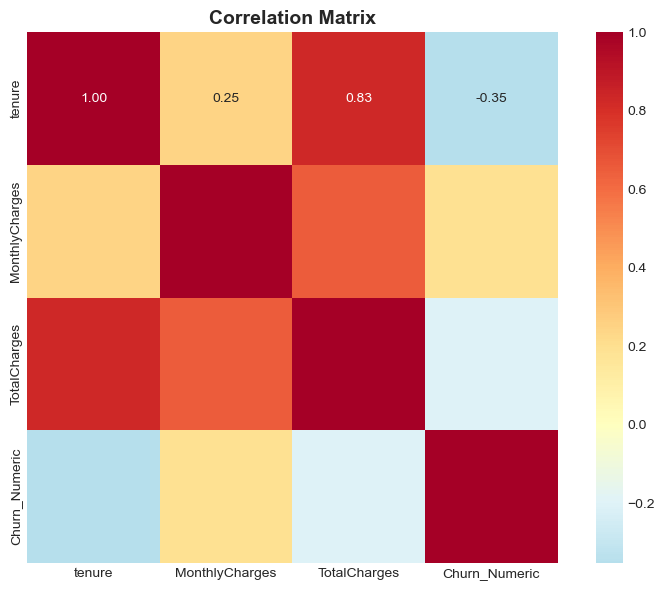

In [15]:
# Encode target for correlation
df['Churn_Numeric'] = (df['Churn'] == 'Yes').astype(int)

# Correlation matrix for numerical features
corr_cols = numerical_cols + ['Churn_Numeric']
corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.2f', square=True, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



In [16]:
# Correlation with target
print("\n" + "=" * 50)
print("CORRELATION WITH CHURN (Numerical Features)")
print("=" * 50)

target_corr = df[corr_cols].corr()['Churn_Numeric'].drop('Churn_Numeric').sort_values(key=abs, ascending=False)
for feat, corr in target_corr.items():
    direction = "📈" if corr > 0 else "📉"
    print(f"{direction} {feat:20} | r = {corr:+.3f}")




CORRELATION WITH CHURN (Numerical Features)
📉 tenure               | r = -0.352
📉 TotalCharges         | r = -0.199
📈 MonthlyCharges       | r = +0.193


## 7. Feature Engineering



In [17]:
print("=" * 50)
print("FEATURE ENGINEERING")
print("=" * 50)

# Create a copy for feature engineering
df_fe = df.copy()

# 1. Tenure buckets
df_fe['tenure_group'] = pd.cut(df_fe['tenure'], 
                                bins=[0, 12, 24, 48, 72],
                                labels=['0-1 Year', '1-2 Years', '2-4 Years', '4+ Years'])
print("✅ Created: tenure_group (bucketed tenure)")

# 2. Charges per tenure (value extraction rate)
df_fe['charges_per_tenure'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)
print("✅ Created: charges_per_tenure")

# 3. Service count
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']
df_fe['service_count'] = df_fe[service_cols].apply(
    lambda row: sum(1 for x in row if x == 'Yes'), axis=1
)
print("✅ Created: service_count")

# 4. Has any add-on service
df_fe['has_addons'] = (df_fe['service_count'] > 0).astype(int)
print("✅ Created: has_addons")

# 5. Has premium support
df_fe['has_premium_support'] = (df_fe['TechSupport'] == 'Yes').astype(int)
print("✅ Created: has_premium_support")

# 6. Contract stability score
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df_fe['contract_stability'] = df_fe['Contract'].map(contract_map)
print("✅ Created: contract_stability")

# 7. High value customer
median_charges = df_fe['MonthlyCharges'].median()
df_fe['is_high_value'] = (df_fe['MonthlyCharges'] > median_charges).astype(int)
print("✅ Created: is_high_value")

# 8. Automatic payment
df_fe['auto_payment'] = df_fe['PaymentMethod'].apply(
    lambda x: 1 if 'automatic' in x.lower() else 0
)
print("✅ Created: auto_payment")

# 9. Senior citizen with dependents (vulnerable segment)
df_fe['senior_alone'] = ((df_fe['SeniorCitizen'] == 1) & 
                          (df_fe['Partner'] == 'No') & 
                          (df_fe['Dependents'] == 'No')).astype(int)
print("✅ Created: senior_alone")

# 10. Monthly to Total ratio (payment consistency indicator)
df_fe['monthly_total_ratio'] = df_fe['MonthlyCharges'] / (df_fe['TotalCharges'] + 1)
print("✅ Created: monthly_total_ratio")



FEATURE ENGINEERING
✅ Created: tenure_group (bucketed tenure)
✅ Created: charges_per_tenure
✅ Created: service_count
✅ Created: has_addons
✅ Created: has_premium_support
✅ Created: contract_stability
✅ Created: is_high_value
✅ Created: auto_payment
✅ Created: senior_alone
✅ Created: monthly_total_ratio


In [18]:
# Validate engineered features correlation with Churn
print("\n" + "=" * 50)
print("ENGINEERED FEATURES CORRELATION WITH CHURN")
print("=" * 50)

engineered_cols = [
    'charges_per_tenure', 'service_count', 'has_addons', 
    'has_premium_support', 'contract_stability', 'is_high_value',
    'auto_payment', 'senior_alone', 'monthly_total_ratio'
]

eng_corr = df_fe[engineered_cols + ['Churn_Numeric']].corr()['Churn_Numeric'].drop('Churn_Numeric')
eng_corr = eng_corr.sort_values(key=abs, ascending=False)

for feat, corr in eng_corr.items():
    direction = "📈" if corr > 0 else "📉"
    strength = "Strong" if abs(corr) > 0.2 else "Moderate" if abs(corr) > 0.1 else "Weak"
    print(f"{direction} {feat:25} | r = {corr:+.3f} | {strength}")




ENGINEERED FEATURES CORRELATION WITH CHURN
📉 contract_stability        | r = -0.397 | Strong
📈 monthly_total_ratio       | r = +0.322 | Strong
📉 auto_payment              | r = -0.210 | Strong
📈 is_high_value             | r = +0.196 | Moderate
📉 has_premium_support       | r = -0.165 | Moderate
📈 senior_alone              | r = +0.151 | Moderate
📉 service_count             | r = -0.088 | Weak
📈 has_addons                | r = +0.079 | Weak
📈 charges_per_tenure        | r = +0.071 | Weak


## 8. Data Cleaning Summary



In [19]:
print("=" * 50)
print("DATA CLEANING STEPS")
print("=" * 50)

print("""
1. TotalCharges Handling:
   - Convert to numeric (pd.to_numeric with errors='coerce')
   - Fill NaN with 0 (new customers with no charges yet)

2. No duplicate rows detected

3. No missing values in other columns

4. Categorical Encoding (for modeling):
   - Binary: Yes/No → 1/0
   - Multi-class: One-Hot Encoding

5. Feature Scaling:
   - StandardScaler for numerical features
   - Required for: tenure, MonthlyCharges, TotalCharges, 
     charges_per_tenure, monthly_total_ratio
""")



DATA CLEANING STEPS

1. TotalCharges Handling:
   - Convert to numeric (pd.to_numeric with errors='coerce')
   - Fill NaN with 0 (new customers with no charges yet)

2. No duplicate rows detected

3. No missing values in other columns

4. Categorical Encoding (for modeling):
   - Binary: Yes/No → 1/0
   - Multi-class: One-Hot Encoding

5. Feature Scaling:
   - StandardScaler for numerical features
   - Required for: tenure, MonthlyCharges, TotalCharges, 
     charges_per_tenure, monthly_total_ratio



In [20]:
# Final cleaned dataset preview
df_clean = df_fe.copy()

# Apply cleaning
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce').fillna(0)
df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})

print("\nCleaned Dataset Shape:", df_clean.shape)
print("\nSample of Cleaned Data:")
df_clean.head()




Cleaned Dataset Shape: (7043, 32)

Sample of Cleaned Data:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Numeric,tenure_group,charges_per_tenure,service_count,has_addons,has_premium_support,contract_stability,is_high_value,auto_payment,senior_alone,monthly_total_ratio
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,0-1 Year,14.925000,1,1,0,0,0,0,0,0.967585
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0,2-4 Years,53.985714,2,1,0,1,0,0,0,0.030124
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1,0-1 Year,36.050000,2,1,0,0,0,0,0,0.493358
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0,2-4 Years,40.016304,3,1,1,1,0,1,0,0.022967
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1,0-1 Year,50.550000,0,0,0,0,1,0,0,0.463151


## 9. Feature Selection Recommendations



In [21]:
print("=" * 50)
print("🎯 RECOMMENDED FEATURES FOR TRAINING")
print("=" * 50)

print("""
CATEGORICAL FEATURES (One-Hot Encode):
├── Contract (Strong predictor - Month-to-month churns most)
├── InternetService (Fiber optic has higher churn)
├── PaymentMethod (Electronic check has highest churn)
├── OnlineSecurity
├── TechSupport
└── PaperlessBilling

NUMERICAL FEATURES (Scale):
├── tenure (Strongest predictor - longer tenure = less churn)
├── MonthlyCharges
├── TotalCharges
├── charges_per_tenure
├── service_count
├── contract_stability
└── monthly_total_ratio

BINARY FEATURES:
├── SeniorCitizen
├── has_premium_support
├── auto_payment
├── is_high_value
└── senior_alone

DROP (Not useful):
├── customerID (identifier)
├── gender (not significant in chi-square)
├── PhoneService (low variance)
└── Partner, Dependents (weak correlation)
""")



🎯 RECOMMENDED FEATURES FOR TRAINING

CATEGORICAL FEATURES (One-Hot Encode):
├── Contract (Strong predictor - Month-to-month churns most)
├── InternetService (Fiber optic has higher churn)
├── PaymentMethod (Electronic check has highest churn)
├── OnlineSecurity
├── TechSupport
└── PaperlessBilling

NUMERICAL FEATURES (Scale):
├── tenure (Strongest predictor - longer tenure = less churn)
├── MonthlyCharges
├── TotalCharges
├── charges_per_tenure
├── service_count
├── contract_stability
└── monthly_total_ratio

BINARY FEATURES:
├── SeniorCitizen
├── has_premium_support
├── auto_payment
├── is_high_value
└── senior_alone

DROP (Not useful):
├── customerID (identifier)
├── gender (not significant in chi-square)
├── PhoneService (low variance)
└── Partner, Dependents (weak correlation)



## 10. Export Clean Data



In [22]:
# Save cleaned dataset
output_path = '../data/customer_churn_cleaned.csv'
df_clean.to_csv(output_path, index=False)
print(f"✅ Cleaned dataset saved to: {output_path}")
print(f"   Shape: {df_clean.shape}")



✅ Cleaned dataset saved to: ../data/customer_churn_cleaned.csv
   Shape: (7043, 32)


In [23]:
print("\n" + "=" * 50)
print("📈 EDA COMPLETE - Ready for Model Training!")
print("=" * 50)



📈 EDA COMPLETE - Ready for Model Training!
